# Bringing tomography and pulses together

In [1]:
from qiskit import IBMQ
import qiskit.tools.jupyter
%qiskit_job_watcher

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
backend = provider.get_backend(open_pulse=True)

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [2]:
backend

/Users/thomassmith/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:377: UserWarning: `rep_time` now has units of seconds(s) rather than microseconds(mu s).
  warnings.warn('`rep_time` now has units of seconds(s) rather '
/Users/thomassmith/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:355: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


<IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
def to_ptm(op):
    paulis = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]
    ptm = np.zeros((4, 4), dtype=complex)
    for i in range(4):
        for j in range(4):
            ptm[i, j] = (paulis[i] * op * paulis[j] * op.dag()).tr()/2
    return qt.Qobj(ptm)

def rotation(theta, phi, lam):
    U = [[np.cos(theta/2), -np.exp(1j*lam) * np.sin(theta/2)], 
         [np.exp(1j*phi) * np.sin(theta/2), np.exp(1j*lam+1j*phi) * np.cos(theta/2)]]
    return qt.Qobj(U)

def objective(angles, *args):
    theta, phi, lam = angles
    U = to_ptm(rotation(theta, phi, lam))
    G, G_ideal = args
    norm = np.linalg.norm((G_ideal - U * G)) ** 2
    return norm

## Process tomography for the Hadamard gate

In [4]:
from qiskit.circuit import QuantumRegister, QuantumCircuit
from qiskit.ignis.verification.tomography import process_tomography_circuits
from qiskit.execute import execute

register = QuantumRegister(1)
circuit = QuantumCircuit(register)
circuit.h(0)

experiments = process_tomography_circuits(circuit, register[0])
#job = execute(experiments, backend, shots=8000)
job = backend.retrieve_job('5e565379abd90800189ccd48')
result = job.result()

print(job.job_id())

5e565379abd90800189ccd48


CP? True. TP? True.
Norm(ideal, real): 0.030388312499999837.


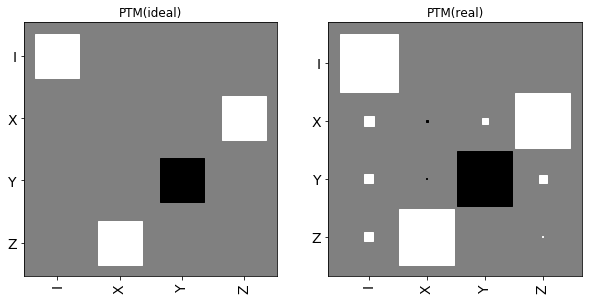

In [16]:
from qiskit.ignis.verification.tomography import ProcessTomographyFitter
from qiskit.quantum_info import PTM
from qiskit.visualization import plot_state_hinton

tomography = ProcessTomographyFitter(result, experiments)
choi = tomography.fit()
ptm = qt.Qobj(PTM(choi).data)

ptm_ideal = to_ptm(qt.hadamard_transform(1))
ptm_norm_before =  np.linalg.norm((ptm - ptm_ideal).full()) ** 2

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_state_hinton(ptm_ideal.dag(), ax_real=axs[0])
plot_state_hinton(ptm.dag(), ax_real=axs[1])
title_list = ['PTM(ideal)', 'PTM(real)']
for idx, ax in enumerate(axs):
    ax.set_title(title_list[idx]);
    ax.set_xticklabels(['I', 'X', 'Y', 'Z'])
    ax.set_yticklabels(['I', 'X', 'Y', 'Z'])

print('CP? '+str(choi.is_cp())+'.', 'TP? '+str(choi.is_tp())+'.')
print('Norm(ideal, real): '+str(ptm_norm_before)+'.')

## Calculating the gate corrections

[ 0.00031082  0.03930947 -0.04514127]
Norm(ideal, ideal corrected): 0.029781972371175167.


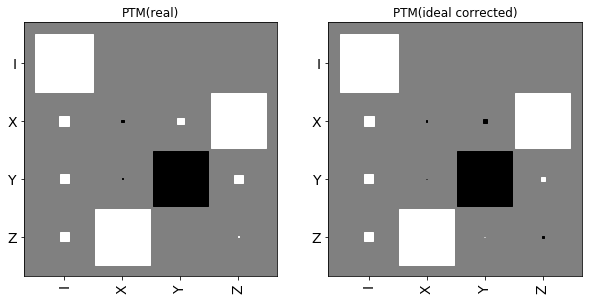

In [6]:
from scipy.optimize import minimize
guess = .5 * np.random.randn(3, 1) 
#bounds = ((np.pi/2, np.pi/2), (np.pi/2, np.pi/2), (np.pi/2, np.pi/2))
solution = minimize(objective, guess, args=(ptm, ptm_ideal), tol=1e-12)
angles = solution.x

theta, phi, lam = angles
U = to_ptm(rotation(theta, phi, lam))

ptm_th = U * ptm
ptm_norm_th =  np.linalg.norm((ptm_th - ptm_ideal).full()) **2

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_state_hinton(ptm.dag(), ax_real=axs[0])
plot_state_hinton(ptm_th.dag(), ax_real=axs[1])
title_list = ['PTM(real)', 'PTM(ideal corrected)']
for idx, ax in enumerate(axs):
    ax.set_title(title_list[idx]);
    ax.set_xticklabels(['I', 'X', 'Y', 'Z'])
    ax.set_yticklabels(['I', 'X', 'Y', 'Z'])

print(angles/np.pi)
print('Norm(ideal, ideal corrected): '+str(ptm_norm_th)+'.')

## Process tomography for the "corrected" Hadamard gate

In [7]:
import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

register = QuantumRegister(1)
circuit_corr = QuantumCircuit(register)
circuit_corr.u3(theta, phi, lam, 0)
circuit_corr.h(0)
circuit_corr.u3(-theta, -lam, -phi, 0)

experiments_corr = process_tomography_circuits(circuit_corr, register[0])
#job_corr = execute(experiments_corr, backend, shots=8000)
job_corr = backend.retrieve_job('5e5654de2aeb3b0019f47d61')
result_corr = job_corr.result()

print(job_corr.job_id())

5e5654de2aeb3b0019f47d61


CP? True. TP? True.
Norm(real corrected, ideal): 0.04579625000000056.
Norm(real corrected, ideal corrected): 0.004014841827276446.


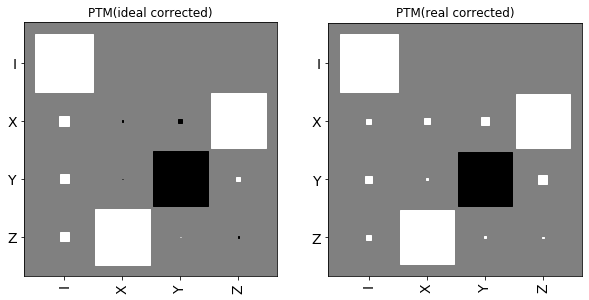

In [17]:
tomography_corr = ProcessTomographyFitter(result_corr, experiments_corr)
choi_corr = tomography_corr.fit()
ptm_corr = qt.Qobj(PTM(choi_corr).data)

ptm_norm_after =  np.linalg.norm((ptm_corr - ptm_ideal).full()) ** 2
ptm_norm_miss =  np.linalg.norm((ptm_corr - ptm_th).full()) ** 2

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_state_hinton(ptm_th.dag(), ax_real=axs[0])
plot_state_hinton(ptm_corr.dag(), ax_real=axs[1])
title_list = ['PTM(ideal corrected)', 'PTM(real corrected)']
for idx, ax in enumerate(axs):
    ax.set_title(title_list[idx]);
    ax.set_xticklabels(['I', 'X', 'Y', 'Z'])
    ax.set_yticklabels(['I', 'X', 'Y', 'Z'])

print('CP? '+str(choi_corr.is_cp())+'.', 'TP? '+str(choi_corr.is_tp())+'.')
print('Norm(real corrected, ideal): '+str(ptm_norm_after)+'.')
print('Norm(real corrected, ideal corrected): '+str(ptm_norm_miss)+'.')

## Exploring the pulses

In [166]:
config = backend.configuration()
defaults = backend.defaults()
inst_sched_map = defaults.instruction_schedule_map
print(inst_sched_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'MEAS', 'u1', 'measure', 'u2', 'id', 'u3', 'x'}
Multi qubit instructions:
)>


### Hadamard

In [167]:
from qiskit.compiler import transpile
transpile(circuit, backend).draw()

┌──────────┐
q0_0: |0>┤ U2(0,pi) ├
         └──────────┘

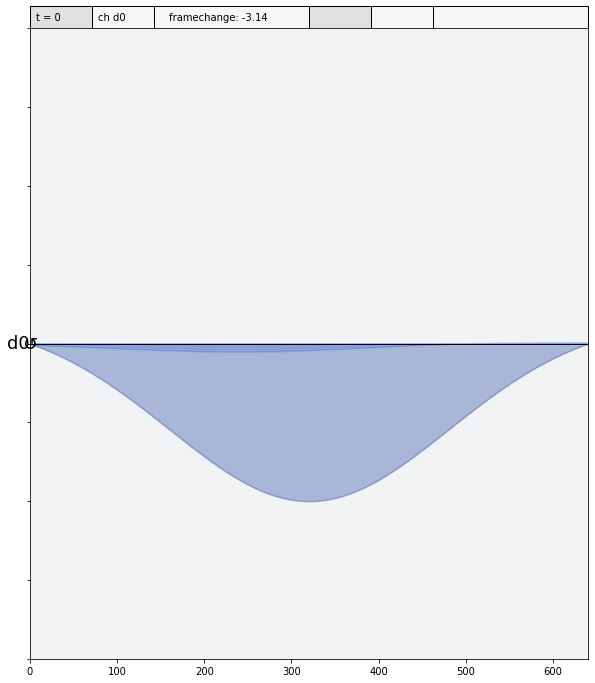

In [168]:
h_pulse = inst_sched_map.get('u2', 0, 0, np.pi)
h_pulse.draw()

### Corrections 

In [169]:
from qiskit import Aer
simulator = Aer.get_backend('unitary_simulator')

circuit_sim = QuantumCircuit(1)
circuit_sim.u3(theta, phi, lam, 0)
circuit_sim.u3(-theta, -lam, -phi, 0)
circuit_sim.draw()

job_sim = execute(circuit_sim, simulator).result().get_unitary(circuit_sim)
print(job_sim)

[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


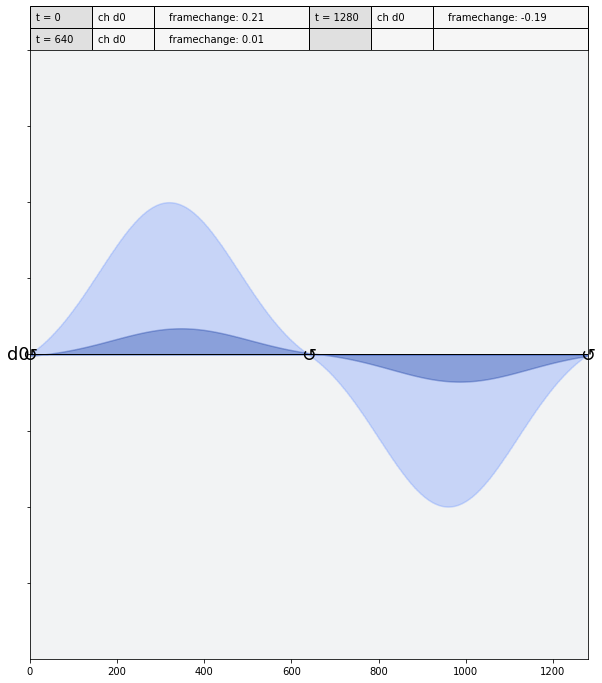

In [170]:
u3_pulse = inst_sched_map.get('u3', 0, theta, phi, lam)
u3_pulse.draw()

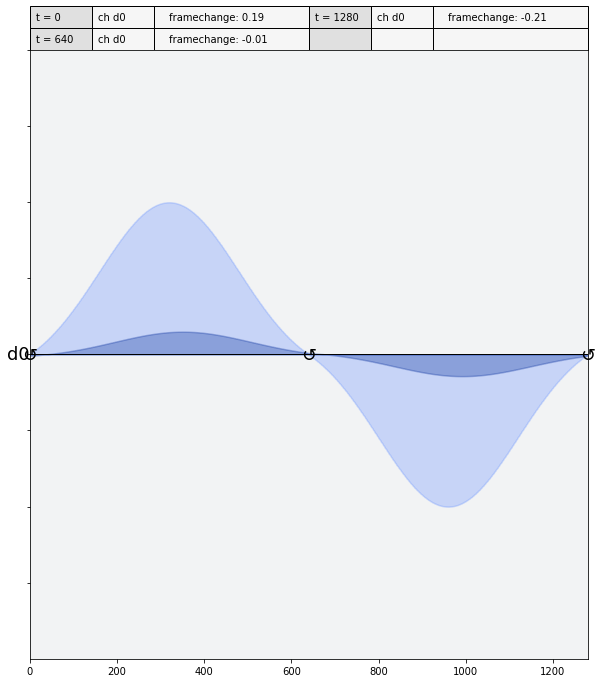

In [171]:
u3d_pulse = inst_sched_map.get('u3', 0, -theta, -lam, -phi)
u3d_pulse.draw()

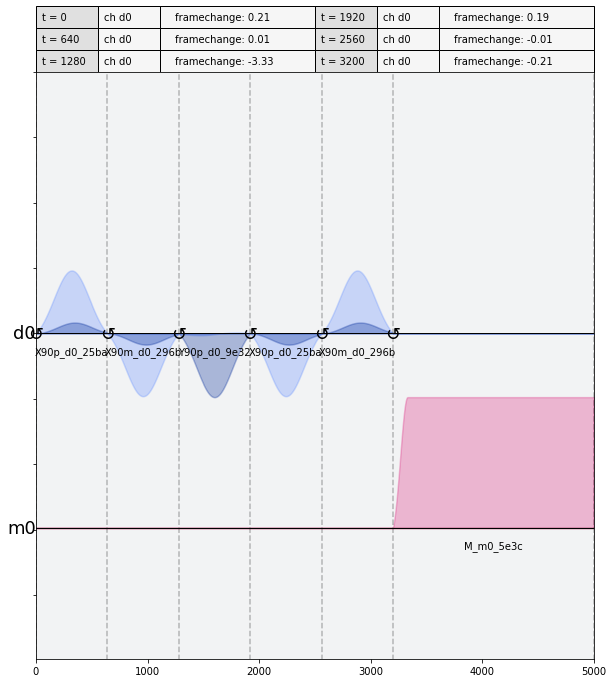

In [175]:
from qiskit.pulse import Schedule, DriveChannel, MeasureChannel

qubit = 0
shots = 8000
scale_factor = 1e-15
    
schedule = Schedule(name='hadamard_corrected')
schedule |= u3_pulse
schedule |= h_pulse << schedule.duration
schedule |= u3d_pulse << schedule.duration
schedule |= measure << schedule.duration

schedule.draw(channels=[DriveChannel(qubit), MeasureChannel(qubit)], label=True, 
              plot_range=[0, 5000])

In [ ]:
#from qiskit.compiler import assemble
#from qiskit.qobj.utils import MeasLevel, MeasReturnType
#jobs = assemble(schedule, backend, shots=shots,
#                meas_level=MeasLevel.KERNELED, meas_return=MeasReturnType.AVERAGE)

         ┌───┐┌───┐ ░ ┌───┐ ░ ┌─────┐┌───┐┌─┐
q0_0: |0>┤ H ├┤ S ├─░─┤ H ├─░─┤ Sdg ├┤ H ├┤M├
         └───┘└───┘ ░ └───┘ ░ └─────┘└───┘└╥┘
 c0_0: 0 ══════════════════════════════════╩═
                                             
         ┌─────────────┐ ░ ┌──────────┐ ░ ┌────────────┐┌─┐
q0_0: |0>┤ U2(pi/2,pi) ├─░─┤ U2(0,pi) ├─░─┤ U2(0,pi/2) ├┤M├
         └─────────────┘ ░ └──────────┘ ░ └────────────┘└╥┘
 c0_0: 0 ════════════════════════════════════════════════╩═
                                                           


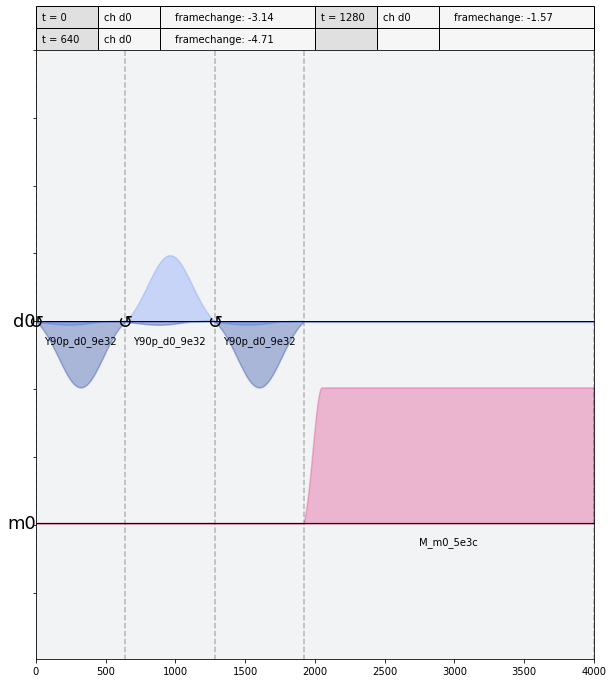

In [179]:
from qiskit.compiler import schedule

idx = 10

experiments_trans = transpile(experiments, backend)
print(experiments[idx].draw())
print(experiments_trans[idx].draw())

schedule(experiments_trans[idx], backend).draw(channels=[DriveChannel(qubit), 
                                                         MeasureChannel(qubit)], 
                                               label=True, plot_range=[0, 4000])

         ┌───┐┌───┐ ░ ┌─────────────────────────────────┐┌───┐»
q1_0: |0>┤ H ├┤ S ├─░─┤ U3(0.00097648,0.12349,-0.14182) ├┤ H ├»
         └───┘└───┘ ░ └─────────────────────────────────┘└───┘»
 c1_0: 0 ═════════════════════════════════════════════════════»
                                                              »
«      ┌──────────────────────────────────┐ ░ ┌─────┐┌───┐┌─┐
«q1_0: ┤ U3(-0.00097648,0.14182,-0.12349) ├─░─┤ Sdg ├┤ H ├┤M├
«      └──────────────────────────────────┘ ░ └─────┘└───┘└╥┘
«c1_0: ════════════════════════════════════════════════════╩═
«                                                            
         ┌─────────────┐ ░ ┌─────────────────────────────┐ ░ ┌────────────┐┌─┐
q1_0: |0>┤ U2(pi/2,pi) ├─░─┤ U3(1.5689,0.018201,-3.1598) ├─░─┤ U2(0,pi/2) ├┤M├
         └─────────────┘ ░ └─────────────────────────────┘ ░ └────────────┘└╥┘
 c1_0: 0 ═══════════════════════════════════════════════════════════════════╩═
                                                      

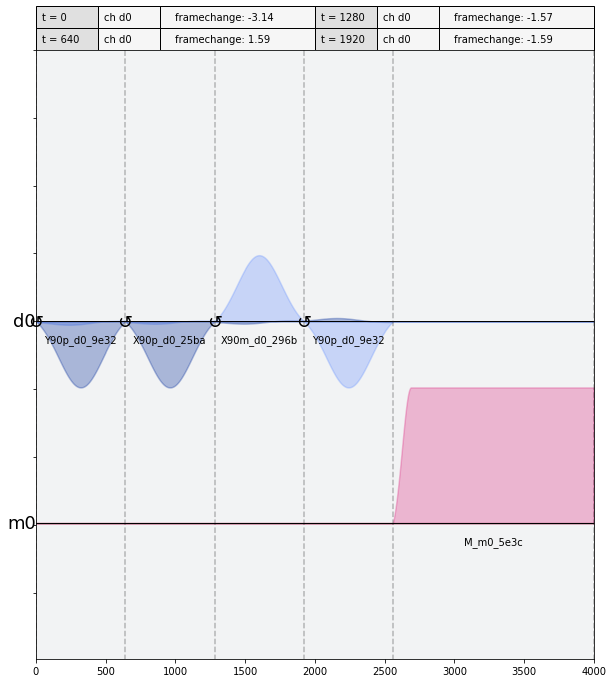

In [180]:
experiments_corr_trans = transpile(experiments_corr, backend)
print(experiments_corr[idx].draw())
print(experiments_corr_trans[idx].draw())

schedule(experiments_corr_trans[idx], backend).draw(channels=[DriveChannel(qubit), 
                                                              MeasureChannel(qubit)], 
                                                    label=True, plot_range=[0, 4000])

In [159]:
register = QuantumRegister(1)
circuit_corr = QuantumCircuit(register)
circuit_corr.u3(theta, phi, lam, 0)
circuit_corr.h(0)
circuit_corr.u3(-theta, -lam, -phi, 0)

transpile(circuit_corr, backend).draw()

┌────────────────────────────┐
q4_0: |0>┤ U3(1.5834,0.02368,-3.1653) ├
         └────────────────────────────┘